# Artificial Neural Networks(ANN)


## Components

### Activation functions

**Sigmoid** 
$$
    g(z) = \frac{1}{1+e^{-z}}
$$

**ReLU**
$$
    g(z) = \begin{cases}
                z, \space z \ge 0 \\
                0, \space z < 0
        \end{cases}
$$

In [2]:
import numpy as np
seed = 42
rng = np.random.default_rng(seed==seed)

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def grad_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def relu(z):
    return np.where(z >= 0, z, 0)

def grad_relu(z):
    return np.where(z >= 0, 1, 0)

# A dictionary of activation functions will be used while inititalising the network
hidden_act = {'sigmoid': sigmoid, 'relu': relu}
grad_hidden_act = {'sigmoid': grad_sigmoid, 'relu': grad_relu}

### Output layer

**Identity**

$$
g(z) = z
$$

**Softmax**

$$
g(Z) =  \left[ {\begin{array}{cc}
                    ... & ... & ...\\
                    ... & \frac{exp(Z_{ij})}{\sum_{j=1}^k  exp(Z_{ij})} & ... \\
                    ... & ... & ... \\
                \end{array} } \right]
$$

In [4]:
def identity(z):
    return z

def softmax(z):
    '''Row-wise softmax'''
    #Check if z is a matrix
    assert z.ndim == 2

    #To prevent overflow, subtract max, row-wise
    z -= z.max(axis=1, keepdims=True)

    #Compute row-wise softmax
    prob = np.exp(z) / np.exp(z).sum(axis = 1, keepdims = True)

    # Check if each row is a probability distribution
    assert np.allclose(prob.sum(axis=1), np.ones(z.shape[0]))
    return prob

output_act = {'softmax': softmax, 'identity': identity}

### Loss

**Least Square**
$$
    L(y, \hat{y}) = \frac{1}{2}.(\hat{y} - y)^T.(\hat{y} - y)
$$

**Categorical Cross Entropy**
$$
    L(Y, \hat{Y}) = -\bf{1}_n^T \space (Y \odot log\hat{Y}) \space \bf{1}_k
$$

In [5]:
def least_square(y, y_hat):
    return 0.5 * np.sum((y_hat - y) * (y_hat - y))

def cce(Y, Y_hat):
    return -np.sum(Y * np.log(Y_hat))

losses = {'least_square': least_square, 'cce': cce}

### Initialization

**Network Architecture**
* number of layers - indexed by `l`
    * $ l = 0 $: Input layer
    * $ 1 \le l \le L -1 $: Hidden layers
    * $l = L$: Output layer
* number of neurons per layer  

In [6]:
## Helper function to compute total number of parameters in the network
def count_params(layers):
    num_params = 0
    for l in range(1, len(layers)):
        num_weights = layers[l-1] * layers[l]
        num_biases = layers[l]
        num_params += (num_weights + num_biases)

    return num_params

#Test
assert count_params([64, 5, 10]) == (64 * 5 + 5) + (5 * 10 + 10)

**Parameter Initilisation**


In [7]:
from cv2 import EMD


def init_params(layers):
    num_params = count_params(layers) # Number of parameters in the network

    W = [None for _ in range(len(layers))] # weights
    b = [None for _ in range(len(layers))] # biases
    gW = [None for _ in range(len(layers))] # gradient of loss wrt weights
    gb = [None for _ in range(len(layers))] # grad loss wrt biases

    # Sample from N(0,1) to initialise the parameters
    theta = rng. standard_normal(num_params) # master params
    gtheta = np.zeros(num_params) # master gradients
    
    #(start, end) specify the portion of the theta that corresponds to the
    #parameter, W_l or b_l
    start, end = 0, 0
    for l in range(1, len(layers)):
        #reshape the section (start, end) an assign it to W[l]
        end = start + layers[l-1] * layers[l]
        W[l] = theta[start: end].reshape(layers[l-1], layers[l])
        gW[l] = gtheta[start: end].reshape(layers[l-1], layers[l])

        #reshape the section(start, end) and assign it to b[l]
        start, end = end, end + layers[l]
        b[l] = theta[start: end].reshape(layers[l])
        gb[l] = gtheta[start: end].reshape(layers[l])
        start = end

    return theta, gtheta, W, b, gW, gb

## test init_params
layers = [64, 32, 10]
params = init_params([6, 32, 10])
for l in range(1, len(layers)):
    #Check if the weights are view of the master vector
    assert params[2][l].base is params[0]
    assert params[3][l].base is params[0]
    assert params[4][l].base is params[1]
    assert params[5][l].base is params[1]


### Forward pass

The forward pass algorithm is as follows. First, we initalise $A_0 = X$. The, we iteratively compute pre-activations and activations for each layer $l$ using the equations givenbelow:
$$
    Z_l = A_{l-1}W_l + b_l
    A_l = g(Z_l)
$$

Finally, the netwrk's output is given by $\hat{y} = A_l$

### Backward pass

For backward pass, we first initialise the gradients of the  pre activations at layer $L$ as $Z_L^{(g)} = \hat{Y} - Y $. The other gradients can then be iteratively updated.

$$
    W_l^{(g)} = A_{l-1}^T Z_l^{(g)} \\
$$
$$
    b_l^{(g)} = Z_l^{(g)^T} \bf{1_n} \\
$$
$$
    A_{l-1}^{(g)} = Z_l^{(g)} W_l^T \\
$$
$$
    Z_{l-1}^{(g)} = A_{l-1}^{(g)} \odot g'(Z_{l-1})
$$

## Network Class

In [29]:
class Network:

    def __init__(self, layers, activation_choice='relu',
                output_choice='softmax', loss_choice='cce'):
        
        self.layers = layers
        # Parameters and gradients
        self.theta, self.gtheta, self.W, self.b, self.gW, self.gb = init_params(layers)

        #Activation functions
        self.ghid = hidden_act[activation_choice]
        self.grad_ghid = grad_hidden_act[activation_choice]
        self.gout = output_act[output_choice]

        #Loss
        self.loss = losses[loss_choice]

    def forward(self, X):
        self.Z = [None for _ in range(len(self.layers))]
        self.A = [None for _ in range(len(self.layers))]
        self.A[0] = X
        self.Z[0] = X

        for l in range(1, len(self.layers)):
            self.Z[l] = self.A[l-1] @ self.W[l] + self.b[l]
            self.A[l] = self.ghid(self.Z[l])
        
        self.A[-1] = self.gout(self.Z[-1])
        return self.A[-1]
        
    def backward(self, Y, Y_hat):
        gZ = [None for _ in range(len(self.layers))]
        gA = [None for _ in range(len(self.layers))]
        gZ[-1] = Y_hat -Y

        for l in range(len(self.layers) - 1, 0, -1):
            self.gW[l][:,:] = self.A[l-1].T @ gZ[l]
            self.gb[l][:] = np.sum(gZ[l].T, axis = 1)

            gA[l-1] = gZ[l] @ self.W[l].T
            gZ[l-1] = gA[l-1] * self.grad_ghid(self.Z[l-1])

    def fit(self, X, Y,
                lr = 0.01, epochs = 100, batch_size = 100):

        self.losses = []

        for epoch in range(epochs):
            #Compute the loss
            Y_hat = self.forward(X)
            self.losses.append(self.loss(Y, Y_hat))
            #Shuffle the dataset
            indices = np.arange(X.shape[0])
            rng.shuffle(indices)
            X, Y = X[indices], Y[indices]
            #number of batches
            num_batches = X.shape[0] // batch_size
            #Mini-batch GD
            for b in range(num_batches):
                Xb = X[b * batch_size: (b + 1) * batch_size]
                Yb = Y[b * batch_size: (b + 1) * batch_size]
                #Compute the prediction for this batch
                Y_hat_b =  self.forward(Xb)
                #Compute the gradients for this batch
                self.backward(Yb, Y_hat_b)
                #Update the gradients of all parameters
                self.theta -= lr*self.gtheta

    def predict(self, X):
        Y_hat = self.forward(X)
        if X.shape[-1] == 1: # regression
            return Y_hat

        else: #classification
            return np.argmax(Y_hat, axis = 1)
    

## Demonstration

We are using digits dataset from sklearn

Sample image with label 0
(1797, 8, 8)


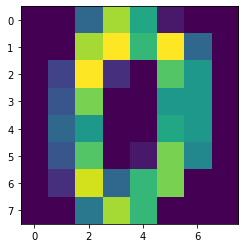

In [30]:
from unicodedata import digit
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.images
#Normalising the data
X /= np.max(X)
y = digits.target
plt.imshow(X[0])
print(f'Sample image with label {y[0]}')
print(X.shape)

#Reshape input
X = X.reshape(-1, 64)
#Input size
isize = X.shape[-1]
#output size
osize = len(np.unique(y))


In [31]:
def onehot_encoder(y):
    k = len(np.unique(y))
    return np.eye(k)[y]

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)
Y_train = onehot_encoder(y_train)
Y_test = onehot_encoder(y_test)

print('Training data, shape:', X_train.shape, Y_train.shape)
print('Test data, shape:', X_test.shape, Y_test.shape)

Training data, shape: (1078, 64) (1078, 10)
Test data, shape: (719, 64) (719, 10)


### Applying ANN

Test-data size = 719
Accuracy =  0.97
Number of parameters = 2410


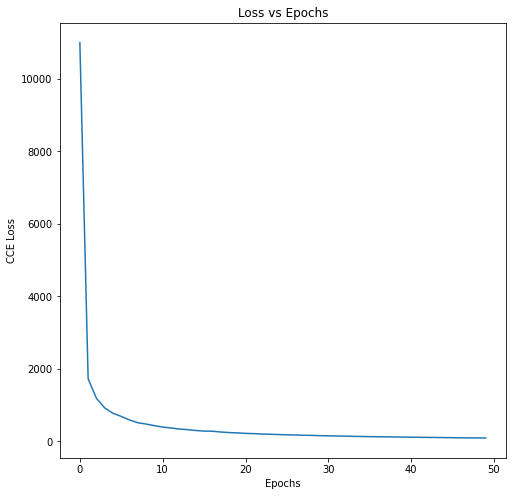

In [34]:
layers = [isize, 32, osize]
network = Network(layers, activation_choice='sigmoid',
                output_choice='softmax', loss_choice='cce')

epochs = 50
network.fit(X_train, Y_train, lr=0.01, epochs=epochs, batch_size=10)

#plot losses
plt.figure(figsize=(8,8))
plt.plot(range(epochs), network.losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('CCE Loss')

#compute accuracy
accuracy = np.sum(network.predict(X_test) == y_test )/ X_test.shape[0]
print(f'Test-data size = {X_test.shape[0]}')
print(f'Accuracy = {accuracy: .2f}')
print(f'Number of parameters = {count_params(layers)}')